In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define the file path
file_path = '../data/hurdat2_1851_2023.txt'
file_path1 = '../data/78073_Nassau_MSLP_18502004_v2.fts'
file_path2 = '../data/72208_Charleston_MSLP_18502004_v2.fts'
file_path3 = '../data/76644_Merida_MSLP_18502004_v2.fts'

In [2]:
def convert_lat_lon(value):
    """Convert latitude and longitude values to float."""
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])

def read_cyclone_file(file_path):
    """Read cyclone data from a file and organize it into a list of cyclones."""
    cyclone_data = []
    current_cyclone = None

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('AL'):
                if current_cyclone is not None:
                    cyclone_data.append(current_cyclone)
                current_cyclone = {'header': line.strip(), 'data': []}
            else:
                if current_cyclone is not None:
                    current_cyclone['data'].append(line.strip().split(','))

    if current_cyclone is not None:
        cyclone_data.append(current_cyclone)
    
    return cyclone_data

def process_cyclone_data(cyclone_data):
    """Process cyclone data into a list of DataFrames."""
    all_cyclone_dfs = []

    for cyclone in cyclone_data:
        df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                    'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                    'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
        # Convert data types where necessary
        df['Date'] = df['Date'].astype(str)
        df['Time'] = df['Time'].astype(str)
        df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
        df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
        df['WindSpeed'] = df['WindSpeed'].astype(int)
        df['Pressure'] = df['Pressure'].astype(int)
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
        df.set_index('Datetime', inplace=True)
        df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
        all_cyclone_dfs.append(df)
    
    return all_cyclone_dfs

def concatenate_cyclone_data(all_cyclone_dfs):
    """Concatenate all cyclone DataFrames into a single DataFrame."""
    return pd.concat(all_cyclone_dfs)

def filter_and_process_data(df, min_lat, max_lat, min_lon, max_lon):
    """Filter data by lat/lon, assign status priority, and extract year."""
    # Filter the data
    
    df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) &
                       (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
    
    filtered_data = df.copy()
    
    # Assign status priority
    priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
    filtered_data['StatusPriority'] = filtered_data['Status'].map(priority_order).fillna(4)
    
    # Extract the year from the Datetime index
    filtered_data['Year'] = filtered_data.index.year
    
    return filtered_data

min_lat, max_lat = 27.5, 29.4
min_lon, max_lon = -81.5, -78.8

# Usage example
cyclone_data = read_cyclone_file(file_path)
all_cyclone_dfs = process_cyclone_data(cyclone_data)
all_data = concatenate_cyclone_data(all_cyclone_dfs)
filtered_data = filter_and_process_data(all_data, min_lat, max_lat, min_lon, max_lon)




In [3]:
# # Initialize variables
# cyclone_data = []
# current_cyclone = None

# # Function to convert latitude and longitude to float
# def convert_lat_lon(value):
#     if 'N' in value or 'E' in value:
#         return float(value[:-1])
#     elif 'S' in value or 'W' in value:
#         return -float(value[:-1])

# # Read the file line by line
# with open(file_path, 'r') as file:
#     for line in file:
#         # Check if the line starts with 'AL' indicating a new cyclone
#         if line.startswith('AL'):
#             if current_cyclone is not None:
#                 cyclone_data.append(current_cyclone)
#             current_cyclone = {'header': line.strip(), 'data': []}
#         else:
#             if current_cyclone is not None:
#                 current_cyclone['data'].append(line.strip().split(','))

# # Append the last cyclone
# if current_cyclone is not None:
#     cyclone_data.append(current_cyclone)

# # Process each cyclone's data
# all_cyclone_dfs = []
# for cyclone in cyclone_data:
#     df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
#                                                 'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
#                                                 'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
#     # Convert data types where necessary
#     df['Date'] = df['Date'].astype(str)
#     df['Time'] = df['Time'].astype(str)
#     df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
#     df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
#     df['WindSpeed'] = df['WindSpeed'].astype(int)
#     df['Pressure'] = df['Pressure'].astype(int)
#     df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
#     df.set_index('Datetime', inplace=True)
#     df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
#     all_cyclone_dfs.append(df)

# # Concatenate all cyclone dataframes into a single dataframe
# all_data = pd.concat(all_cyclone_dfs)

# # Move the Cyclone column to the first position
# columns = ['Cyclone'] + [col for col in all_data.columns if col != 'Cyclone']
# all_data = all_data[columns]

# # Define the latitude and longitude range for filtering
# min_lat, max_lat = 27.5, 29.4
# min_lon, max_lon = -81.5, -78.8

# # Filter the data based on the specified latitude and longitude range
# filtered_data = all_data[(all_data['Latitude'] >= min_lat) & (all_data['Latitude'] <= max_lat) &
#                          (all_data['Longitude'] >= min_lon) & (all_data['Longitude'] <= max_lon)]

# # Define the priority order for statuses
# priority_order = {'HU': 1, 'TS': 2, 'TD': 3}
# filtered_data['StatusPriority'] = filtered_data['Status'].map(priority_order).fillna(4)

# # Extract the year from the Datetime column
# filtered_data['Year'] = filtered_data.index.year

# Group by year and count unique cyclones
#cyclones_per_year = filtered_data.groupby('Year')['Cyclone'].nunique()

In [4]:
def analyze_hurricanes(filtered_data):
    """Analyze hurricane data to get trends and binary indicators."""
    only_hurricane = filtered_data.copy()
    only_hurricane['Status'] = only_hurricane['Status'].astype(str).str.strip()
    only_hurricane = only_hurricane[only_hurricane['Status'] == 'HU']

    # Calculate hurricane trends
    hu_trend = only_hurricane.groupby('Year')['Cyclone'].nunique()
    all_years = pd.Series(0, index=np.arange(filtered_data['Year'].min(), 
                                             filtered_data['Year'].max() + 1))
    hu_trend = hu_trend.reindex(all_years.index, fill_value=0)
    hu_trend = pd.DataFrame(hu_trend)
    hu_trend.rename(columns={'Cyclone': 'Hurricanes'}, inplace=True)
    hu_trend.index.name = 'Year'

    # Create binary hurricane data
    hu_binary = hu_trend.copy()
    hu_binary['Hurricanes'] = hu_binary['Hurricanes'].apply(lambda x: 1 if x > 0 else 0)
    
    return hu_trend, hu_binary

# Analyze hurricanes
hu_trend, hu_binary = analyze_hurricanes(filtered_data)

In [5]:
# only_huricane = filtered_data.copy()
# only_huricane['Status'] = only_huricane['Status'].astype(str)
# only_huricane['Status'] = only_huricane['Status'].str.strip()
# only_huricane = only_huricane[only_huricane['Status'] == 'HU']

In [6]:
# hu_trend = only_huricane.groupby('Year')['Cyclone'].nunique()
# all_years = pd.Series(0, index=np.arange(filtered_data['Year'].min(), 
#                                          filtered_data['Year'].max() + 1))
# hu_trend = hu_trend.reindex(all_years.index, fill_value=0)
# hu_trend = pd.DataFrame(hu_trend)
# hu_trend.rename(columns={'Cyclone': 'Hurricanes'}, inplace=True)
# hu_trend.index.name = 'Year'

Dump this hu_trend file for trend line charts extending back to 1856.

In [7]:
# hu_binary = hu_trend.copy()
# hu_binary['Hurricanes'] = hu_binary['Hurricanes'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
# For the sea level pressure stations. 
# columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual']
# drop_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
#                                 'Jun', 'Jul', 'Nov', 'Dec']

In [9]:
def process_slp_data(file_path, columns, drop_columns, months, replace_value, rename_column):
    """Process the data from reading to preparation for merge."""
    # Read and initial processing
    data = pd.read_csv(file_path, delim_whitespace=True, names=columns)
    data = data[1:].drop(columns=drop_columns)
    
    # Convert specified columns to float
    data[months[-2:]] = data[months[-2:]].astype(float)
    
    # Replace specified values and forward fill missing data
    data.replace(replace_value, pd.NA, inplace=True)
    data.ffill(inplace=True)
    
    # Calculate annual values
    data['Annual'] = data[months].mean(axis=1) - data[months].mean(axis=1).mean()
    
    # Prepare for merging
    data_copy = data.copy()
    data_copy['Year'] = data_copy['Year'].astype(int)
    data_copy = data_copy[['Year', 'Annual']]
    data_copy.set_index('Year', inplace=True)
    data_copy.rename(columns={'Annual': rename_column}, inplace=True)
    
    return data_copy

columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual']
drop_columns_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                'Jun', 'Jul', 'Nov', 'Dec']
months = ['Aug', 'Sep', 'Oct']
replace_value = -999.9

meridia_mean = process_slp_data(file_path3, columns, drop_columns_list, months, replace_value, 'Meridia_slp')
charleston_mean = process_slp_data(file_path2, columns, drop_columns_list, months, replace_value, 'Charleston_slp')
nassau_mean = process_slp_data(file_path1, columns, drop_columns_list, months, replace_value, 'Nassau_slp')

In [12]:
# meridia = pd.read_csv(file_path3, delim_whitespace=True, names=columns)
# meridia = meridia[1:]
# meridia = meridia.drop(columns=drop_columns_list)
# meridia[['Sep', 'Oct']] = meridia[['Sep', 'Oct']].astype(float)
# meridia.replace(-999.9, pd.NA, inplace=True)
# meridia = meridia.ffill()
# meridia['Annual'] = meridia[['Aug', 'Sep', 'Oct']].mean(axis=1) - meridia[['Aug', 'Sep', 'Oct']].mean(axis=1).mean()
# # Make a copy below to merge into df.
# meridia_mean = meridia.copy()
# meridia_mean['Year'] = meridia_mean['Year'].astype(int)
# meridia_mean = meridia_mean[['Year', 'Annual']]
# meridia_mean.set_index('Year', inplace=True)
# meridia_mean.rename(columns={'Annual': 'Meridia_slp'}, inplace=True)

In [19]:
# charleston = pd.read_csv(file_path2, delim_whitespace=True, names=columns)
# charleston = charleston[1:]
# charleston = charleston.drop(columns=drop_columns_list)
# charleston[['Sep', 'Oct']] = charleston[['Sep', 'Oct']].astype(float)
# charleston.replace(-999.9, pd.NA, inplace=True)
# charleston = charleston.ffill()
# charleston['Annual'] = charleston[['Aug', 'Sep', 'Oct']].mean(axis=1) - charleston[['Aug', 'Sep', 'Oct']].mean(axis=1).mean()

# charleston_mean = charleston.copy()
# charleston_mean['Year'] = charleston_mean['Year'].astype(int)
# charleston_mean = charleston_mean[['Year', 'Annual']]
# charleston_mean.set_index('Year', inplace=True)
# charleston_mean.rename(columns={'Annual': 'Charleston_slp'}, inplace=True)

In [21]:
# nassau = pd.read_csv(file_path1, delim_whitespace=True, names=columns)
# nassau = nassau[1:]
# nassau = nassau.drop(columns=drop_columns_list)
# nassau[['Sep', 'Oct']] = nassau[['Sep', 'Oct']].astype(float)
# nassau.replace(-999.9, pd.NA, inplace=True)
# nassau = nassau.ffill()
# nassau['Annual'] = nassau[['Aug', 'Sep', 'Oct']].mean(axis=1) - nassau[['Aug', 'Sep', 'Oct']].mean(axis=1).mean()

# nassau_mean = nassau.copy()
# nassau_mean['Year'] = nassau_mean['Year'].astype(int)
# nassau_mean = nassau_mean[['Year', 'Annual']]
# nassau_mean.set_index('Year', inplace=True)
# nassau_mean.rename(columns={'Annual': 'Nassau_slp'}, inplace=True)

In [555]:
amo_long_tmp = pd.read_csv('../data/amo_sst.txt', delim_whitespace=True,
                           names=columns)
amo_long_tmp = amo_long_tmp.drop(columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Nov', 'Dec'])
amo_long_tmp['Annual'] = np.mean(amo_long_tmp.loc[:, 'Jun':'Oct'].values, axis=1)
amo_long_tmp = amo_long_tmp[['Year', 'Annual']]
amo_long_tmp.rename(columns={'Annual': 'AMO_Anomaly'}, inplace=True)
amo_long_tmp.set_index('Year', inplace=True)

Uploading these files to help with the imputer. 

In [556]:
tna_sst = pd.read_csv('../data/TNA_sst.txt', delim_whitespace=True, index_col='Year')
amm_sst = pd.read_csv('../data/AMM_sst.txt', delim_whitespace=True, index_col='Year')
rh_value = pd.read_csv('../data/rh_mdr.txt', delim_whitespace=True, index_col='Year')

hu_binary_amo_df - used for first AMO Model. This file can be dumped into data.

In [557]:
hu_binary_amo_df = hu_binary.merge(amo_long_tmp, on='Year')
hu_amo_df = hu_trend.merge(amo_long_tmp, on='Year')

Imputer used to get the SLP values from 2005-2022 for the three stations. 

In [558]:
slp_df = amo_long_tmp.join([nassau_mean, charleston_mean, meridia_mean, tna_sst, amm_sst, rh_value], how='left')
df_imputer = slp_df[94:]
mice_imputer = IterativeImputer(random_state=42)
df_imputer = pd.DataFrame(mice_imputer.fit_transform(df_imputer), columns=df_imputer.columns)
df_imputer = pd.DataFrame(mice_imputer.transform(df_imputer), columns=df_imputer.columns)
df_imputer = df_imputer[['Nassau_slp', 'Charleston_slp', 'Meridia_slp']]
imputed_slp = df_imputer[-18:]
imputed_slp = imputed_slp.set_index(slp_df.index[-18:])

In [559]:
# Adding the imputed numbers to the sea level pressure stations. 
only_slp_stations = nassau_mean.join([charleston_mean, meridia_mean], how='left')
only_slp_stations = pd.concat([only_slp_stations, imputed_slp])

In [560]:
# Combining the SLP stations and binary hurricanes for the second model
hu_slp_df = only_slp_stations.merge(hu_binary, on='Year')

Dump the 3 dataframes for model and chart processing. 

In [534]:
# joblib.dump(hu_binary_amo_df, '../joblib_files/hu_binary_amo_df.joblib')
# joblib.dump(hu_slp_df, '../joblib_files/hurricane_slp_df.joblib')
# joblib.dump(hu_amo_df, '../joblib_files/hu_amo_original.joblib')

Optimization terminated successfully.
         Current function value: 0.449459
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             Hurricanes   No. Observations:                  167
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                 0.04543
Time:                        18:37:54   Log-Likelihood:                -75.060
converged:                       True   LL-Null:                       -78.632
Covariance Type:            nonrobust   LLR p-value:                  0.007522
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6899      0.231     -7.331      0.000      -2.142      -1.238
AMO_Anomaly     2.6650    

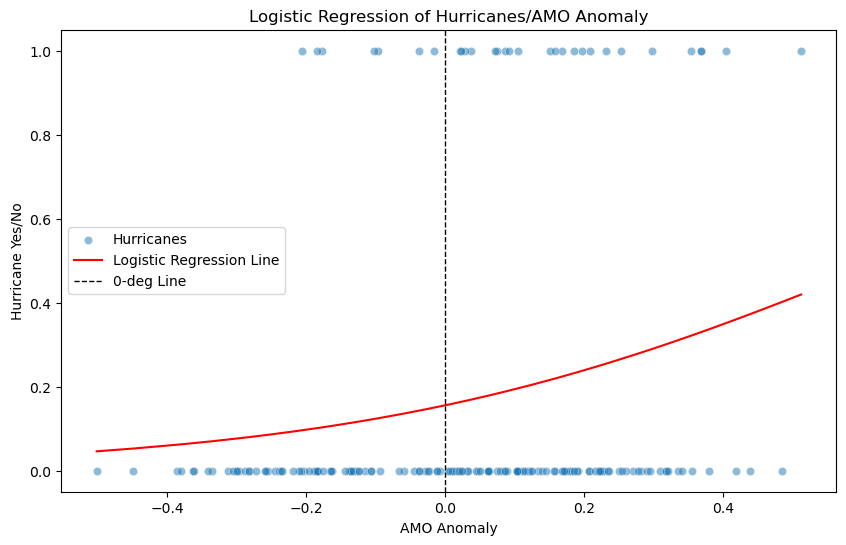

In [561]:
# Prepare the data for logistic regression
X = hu_binary_amo_df['AMO_Anomaly']
y = hu_binary_amo_df['Hurricanes']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the model
print(logit_model.summary())

# Extract predictions
predictions = logit_model.predict(X)

# Visualizations
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AMO_Anomaly', y='Hurricanes', data=hu_binary_amo_df, label='Hurricanes', alpha=0.5)
sns.lineplot(x=hu_binary_amo_df['AMO_Anomaly'], y=predictions, color='red', label='Logistic Regression Line')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1, label='0-deg Line')
plt.xlabel('AMO Anomaly')
plt.ylabel('Hurricane Yes/No')
plt.title('Logistic Regression of Hurricanes/AMO Anomaly')
plt.legend(loc='center left')
plt.show()

In [536]:
#joblib.dump(logit_model, '../models/initial_regression_model.joblib')

In [562]:
hu_slp_df = hu_slp_df.merge(amo_long_tmp, on='Year')
hu_slp_df.describe()

,Nassau_slp,Charleston_slp,Meridia_slp,Hurricanes,AMO_Anomaly
count,167.000000,167.000000,167.000000,167.000000,167.000000
mean,-0.016699,-0.092301,-0.030850,0.179641,0.026807
std,0.765253,0.791345,0.883350,0.385042,0.213811
min,-1.997419,-2.487527,-3.432473,0.000000,-0.501800
25%,-0.480753,-0.620860,-0.549140,0.000000,-0.141400
50%,-0.064086,-0.120860,0.034194,0.000000,0.043800
75%,0.384177,0.462473,0.567527,0.000000,0.185200
max,2.269247,1.979140,1.967527,1.000000,0.512400


In [563]:
X2 = hu_slp_df.drop(columns=['Hurricanes'])
y2 = hu_slp_df['Hurricanes']

In [539]:
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.40, 
#                                                         shuffle=True, stratify=y2, 
#                                                         random_state=42)

In [564]:
# Check for consistency in the number of samples
assert len(X2) == len(y2), "Inconsistent number of samples between X2 and y2"

# Split the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.22, random_state=42)

# Check for consistency after splitting
assert len(X_train2) == len(y_train2), "Inconsistent number of samples between X_train2 and y_train2"
assert len(X_test2) == len(y_test2), "Inconsistent number of samples between X_test2 and y_test2"

# Initialize and train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=300,
                                       class_weight='balanced', 
                                       max_depth=10,
                                       min_samples_split=2,
                                       min_samples_leaf=3,
                                       max_features='sqrt')
rf_classifier.fit(X_train2, y_train2)

# Make predictions on the test set
threshold = rf_classifier.predict_proba(X_test2)[:,1]
y_pred_rf_classifier = (threshold >= 0.44).astype(int)
#y_pred_rf_classifier = rf_classifier.predict(X_test2)

# Evaluate the model
accuracy = accuracy_score(y_test2, y_pred_rf_classifier)
precision = precision_score(y_test2, y_pred_rf_classifier, average='weighted', zero_division=0)
recall = recall_score(y_test2, y_pred_rf_classifier, average='weighted')
f1 = f1_score(y_test2, y_pred_rf_classifier, average='weighted')
conf_matrix = confusion_matrix(y_test2, y_pred_rf_classifier)

accuracy, precision, recall, f1, conf_matrix

(0.7567567567567568,
 0.7699207828518173,
 0.7567567567567568,
 0.7628034814475493,
 array([[25,  5],
        [ 4,  3]]))

In [541]:
#joblib.dump(rf_classifier, '../models/rf_model.joblib')

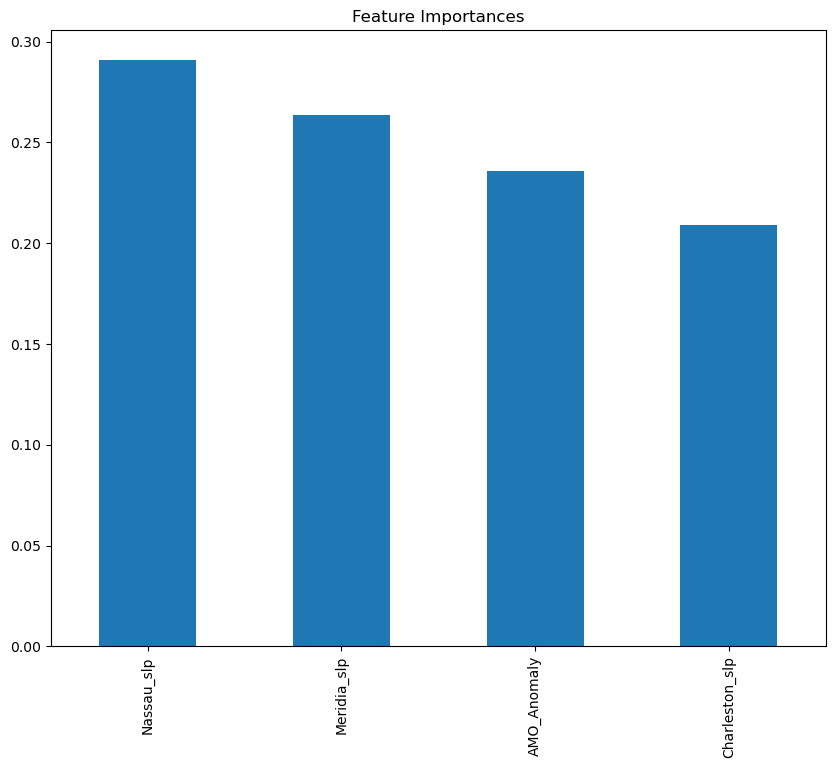

In [565]:
feature_importance = pd.Series(rf_classifier.feature_importances_, index=X2.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
feature_importance.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

In [543]:
from sklearn.metrics import precision_score, make_scorer
# Set up k-fold cross-validation
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=40)
precision_scorer = make_scorer(precision_score, zero_division=0)

# Perform cross-validation and compute metrics
accuracy_scores = cross_val_score(rf_classifier, X2, y2, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(rf_classifier, X2, y2, cv=kf, scoring=precision_scorer)
recall_scores = cross_val_score(rf_classifier, X2, y2, cv=kf, scoring='recall')
f1_scores = cross_val_score(rf_classifier, X2, y2, cv=kf, scoring='f1')

# Display the metrics
accuracy_mean = accuracy_scores.mean()
precision_mean = precision_scores.mean()
recall_mean = recall_scores.mean()
f1_mean = f1_scores.mean()

accuracy_mean, precision_mean, recall_mean, f1_mean

(0.7064459930313589,
 0.16269841269841268,
 0.13392857142857142,
 0.10624999999999998)

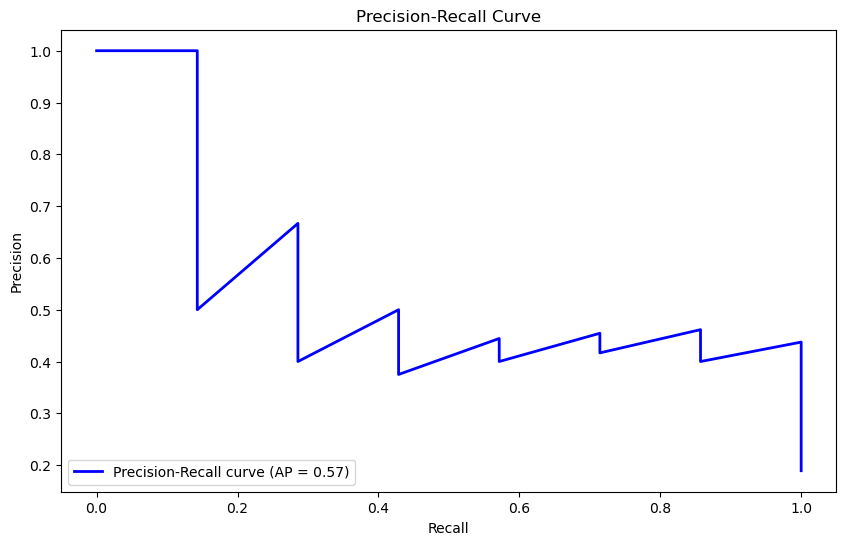

In [544]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_prob = rf_classifier.predict_proba(X_test2)[:, 1]

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test2, y_pred_prob)
average_precision = average_precision_score(y_test2, y_pred_prob)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()